# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

# 方案1：分步安装
!apt update
!apt install python3-dev build-essential swig cmake python-opengl xvfb -y
!pip install wheel setuptools
!pip install box2d-py --no-cache-dir
!pip install gym==0.21.0
!pip install pyvirtualdisplay tqdm numpy torch

In [2]:
!pip install swig
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay tqdm numpy torch


Next, set up virtual display，and import all necessaary packages.

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [3]:
import random
import numpy as np
import torch

seed = 543 # Do not change this

def fix(env, seed):
    # 兼容新旧版本的方法
    try:
        env.seed(seed)  # 旧版本
    except AttributeError:
        pass  # 新版本没有seed方法

    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [4]:
%%capture
#import gym
import gymnasium as gym
import random
#env = gym.make('LunarLander-v2')
env = gym.make('LunarLander-v3')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [5]:
print(env.observation_space)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [7]:
initial_state, _ = env.reset()
print(initial_state)

[ 0.00221968  1.4038155   0.22480384 -0.3157555  -0.00256515 -0.05092134
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [8]:
random_action = env.action_space.sample()
print(random_action)

3


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [9]:
print(env.observation_space)
print(env.action_space)

initial_state, _ = env.reset()
print(initial_state)

random_action = env.action_space.sample()
print(random_action)

observation, reward, terminated, truncated, info = env.step(random_action)
done = terminated or truncated

print(done)
print(reward)

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Discrete(4)
[-0.00659008  1.4115452  -0.6675211   0.02775878  0.00764305  0.15120342
  0.          0.        ]
1
False
-1.6051817544328333


In [10]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [11]:
print(reward)

-1.6051817544328333


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

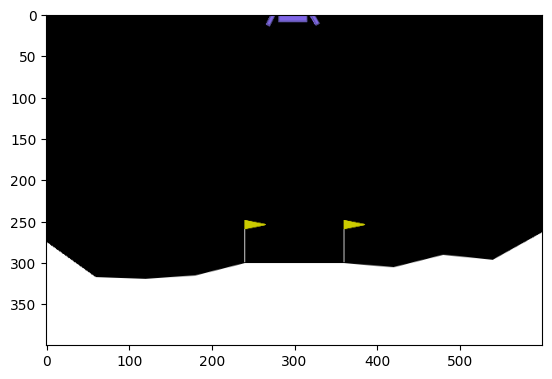

In [12]:
import matplotlib.pyplot as plt
from IPython import display

state, _ = env.reset()

# 创建一个临时的渲染环境
render_env = gym.make('LunarLander-v3', render_mode='rgb_array')
render_env.reset()

img = plt.imshow(render_env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [14]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Lastly, build a network and agent to start training.

In [15]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [16]:
agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 500 time

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state, _ = env.reset()  # 新版本gymnasium需要接收两个值
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state)
            # 修正gymnasium的step返回值
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # 组合两个结束条件

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward)

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    print(f"rewards looks like ", np.shape(rewards))

    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    rewards = np.array(rewards)  # 确保是numpy数组
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

    # 每50个batch保存一次模型（可选）
    if (batch + 1) % 50 == 0:
        torch.save({
            'model_state_dict': agent.network.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
            'batch': batch + 1,
            'avg_total_rewards': avg_total_rewards,
            'avg_final_rewards': avg_final_rewards,
        }, f'/content/drive/MyDrive/lunar_lander_model_batch_{batch+1}.pth')
        print(f"Model saved at batch {batch+1}")

# 训练完成后保存最终模型
torch.save({
    'model_state_dict': agent.network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'batch': NUM_BATCH,
    'avg_total_rewards': avg_total_rewards,
    'avg_final_rewards': avg_final_rewards,
}, '/content/drive/MyDrive/lunar_lander_model_final.pth')

print("Final model saved to Google Drive!")

# 同时保存训练历史
np.save('/content/drive/MyDrive/avg_total_rewards.npy', avg_total_rewards)
np.save('/content/drive/MyDrive/avg_final_rewards.npy', avg_final_rewards)
print("Training history saved!")

  0%|          | 0/500 [00:00<?, ?it/s]

rewards looks like  (482,)
logs prob looks like  torch.Size([482])
torch.from_numpy(rewards) looks like  torch.Size([482])
rewards looks like  (503,)
logs prob looks like  torch.Size([503])
torch.from_numpy(rewards) looks like  torch.Size([503])
rewards looks like  (487,)
logs prob looks like  torch.Size([487])
torch.from_numpy(rewards) looks like  torch.Size([487])
rewards looks like  (601,)
logs prob looks like  torch.Size([601])
torch.from_numpy(rewards) looks like  torch.Size([601])
rewards looks like  (393,)
logs prob looks like  torch.Size([393])
torch.from_numpy(rewards) looks like  torch.Size([393])
rewards looks like  (557,)
logs prob looks like  torch.Size([557])
torch.from_numpy(rewards) looks like  torch.Size([557])
rewards looks like  (488,)
logs prob looks like  torch.Size([488])
torch.from_numpy(rewards) looks like  torch.Size([488])
rewards looks like  (694,)
logs prob looks like  torch.Size([694])
torch.from_numpy(rewards) looks like  torch.Size([694])
rewards looks li

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


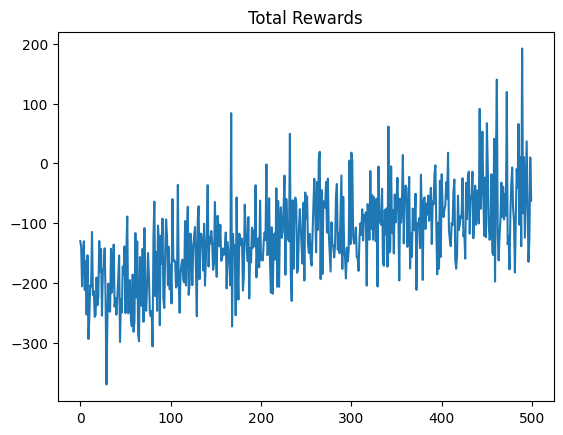

In [17]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


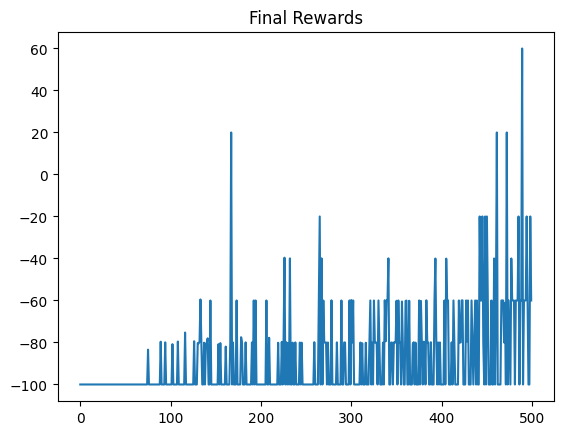

In [18]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

Test 5 total reward: 209.02662390689193
Average test reward: -45.51697811276556


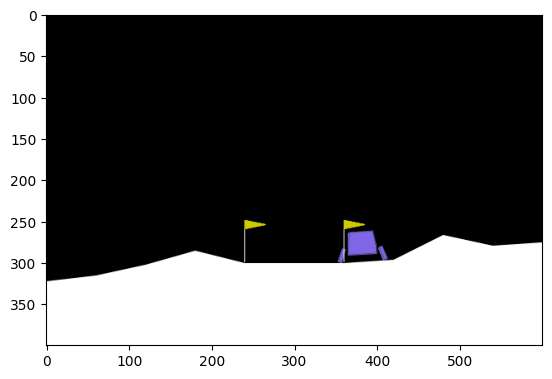

In [21]:
import os

# 尝试加载保存的模型
try:
    if os.path.exists('/content/drive/MyDrive/lunar_lander_model_final.pth'):
        checkpoint = torch.load('/content/drive/MyDrive/lunar_lander_model_final.pth',
                              weights_only=False)
        agent.network.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded from saved checkpoint!")
    else:
        print("No saved model found, using current trained model")
except:
    print("Failed to load saved model, using current trained model")

# 创建测试环境
test_env = gym.make('LunarLander-v3', render_mode='rgb_array')
fix(test_env, seed)
agent.network.eval()

NUM_OF_TEST = 5
test_total_reward = []
action_list = []

for i in range(NUM_OF_TEST):
    actions = []
    state, _ = test_env.reset()

    img = plt.imshow(test_env.render())

    total_reward = 0
    done = False

    while not done:
        action, _ = agent.sample(state)
        actions.append(action)
        state, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated

        total_reward += reward

        img.set_data(test_env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

    print(f"Test {i+1} total reward: {total_reward}")
    test_total_reward.append(total_reward)
    action_list.append(actions)

print(f"Average test reward: {np.mean(test_total_reward)}")

In [22]:
print(np.mean(test_total_reward))

-45.51697811276556


Action list

In [24]:
print("Action list looks like ", action_list)
#print("Action list's shape looks like ", np.shape(action_list))
print("Action list's shape looks like ", len(action_list), "episodes")
for i, actions in enumerate(action_list):
    print(f"Episode {i+1}: {len(actions)} actions")

Action list looks like  [[3, 0, 1, 3, 2, 0, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 0, 3, 3, 0, 2, 2, 2, 3, 2, 0, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Analysis of actions taken by agent

In [25]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{3: 263, 0: 198, 1: 381, 2: 682}


Saving the result of Model Testing


In [27]:
PATH = "/content/drive/MyDrive/Action_List.npy" # Can be modified into the name or path you want
#np.save(PATH ,np.array(action_list))
np.save(PATH, np.array(action_list, dtype=object))

### This is the file you need to submit !!!
Download the testing result to your device



In [28]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : -42.94
Your reward is : -160.86
Your reward is : -111.45
Your reward is : -570.52
Your reward is : -257.73


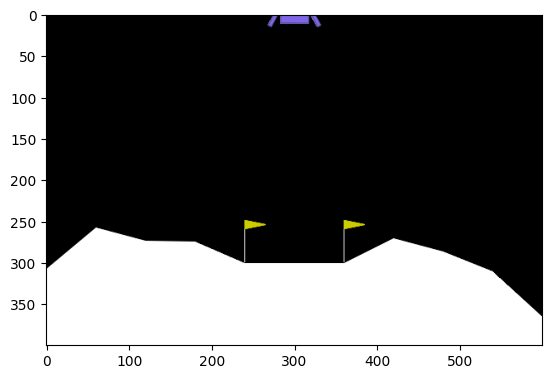

In [30]:
action_list = np.load(PATH, allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this

# 创建一个带渲染功能的测试环境
test_env = gym.make('LunarLander-v3', render_mode='rgb_array')
fix(test_env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
    print("Wrong format of file !!!")
    exit(0)

for actions in action_list:
    state, _ = test_env.reset()
    img = plt.imshow(test_env.render())

    total_reward = 0
    done = False

    for action in actions:

        state, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
        if done:
            break

    print(f"Your reward is : %.2f" % total_reward)
    test_total_reward.append(total_reward)

# Your score

In [31]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -228.70


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
